In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from geemap import ml
from sklearn import ensemble

import geemap, ee

import warnings
warnings.filterwarnings("ignore")

In [2]:
try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()

In [3]:
import sys  
sys.path.insert(0, '../lib/')
import sand_classification as sc
import quality_mosaic as qm

#### Define Functions

In [4]:
def get_classifier_from_ee(modelname:str):
    ### Specify Asset ID
    asset_id = f"projects/gee-sand/assets/{modelname}"

    #### Load classifier
    rf_fc = ee.FeatureCollection(asset_id)

    # convert it to a classifier, very similar to the `ml.trees_to_classifier` function
    new_rf = ml.fc_to_classifier(rf_fc)
    
    return new_rf


def get_confusion_matrix(classified):
    classified = classified.remap(
      [0, 1, 2, 3, 4, 5, 6, 7], 
      [0, 1, 2, 0, 0, 0, 0, 0], 
        'classification'
    )

    classified = classified.remap(
      [0, 1, 2, 3, 4, 5, 6, 7], 
      [0, 1, 2, 0, 0, 0, 0, 0], 
        'classcode'
    )

    test_accuracy = classified.errorMatrix('classcode', 'classification')
    mat = np.array(test_accuracy.getInfo())
    return mat

def support(mat:np.array):
    return np.sum(mat, axis = 1)/np.sum(mat)

def accuracy(mat:np.array):
    return np.sum(np.diagonal(mat))/np.sum(mat)

def precision(mat:np.array):
    return np.nan_to_num(np.diagonal(mat)/np.sum(mat, axis = 0))
    
def recall(mat:np.array):
    return np.nan_to_num(np.diagonal(mat)/np.sum(mat, axis = 1))

def f1_score(mat:np.array):
    prec = precision(mat)
    rec = recall(mat)
    return np.nan_to_num(2 * prec * rec / (prec + rec))

def macro_precision(mat:np.array):
    assert mat.shape[0] > 2
    return np.mean(precision(mat))

def macro_recall(mat:np.array):
    assert mat.shape[0] > 2
    return np.mean(recall(mat))

def macro_f1score(mat:np.array):
    assert mat.shape[0] > 2
    return np.mean(f1_score(mat))

def sklearn_metrics_table(mat:np.array, class_labels = None):
    panela = np.stack([precision(mat), recall(mat), f1_score(mat), np.sum(mat, axis = 1)], axis = 1)
    panelb = np.stack([[np.nan,np.nan  , accuracy(mat), np.sum(mat)], 
                       [macro_precision(mat), macro_recall(mat), macro_f1score(mat), np.sum(mat)]])


    assert panela.shape[1] == panelb.shape[1]
    mtable = pd.DataFrame(np.append(panela, panelb).reshape(panela.shape[0] + panelb.shape[0], panela.shape[1]))
    
    
    if class_labels:
        assert panela.shape[0] == len(class_labels)
        mtable.index = class_labels + ['accuracy', 'macro avg']
    else:
        mtable.index = ['','', ''] + ['accuracy', 'macro avg']
        
    mtable.columns = ['precision', 'recall', 'f1-score', 'support']
    
    return mtable.fillna('')

def metrics_table(mat:np.array, class_labels):
    panela = np.stack([class_labels, precision(mat), recall(mat), f1_score(mat), np.sum(mat, axis = 1)], axis= 1)
    panela = pd.DataFrame(panela)
    panela.columns = ['class', 'precision', 'recall', 'f1-score', 'support']
    return panela
    
    
    

#### Load Image for Validation

In [5]:
####Load an image
roi_buffer_m = 5000

date = '2022-05-09'
max_search_window_months = 3
median_samples = 5
mosaic_method = 'median'

# lon, lat = 84.2047028760486,24.90192702360151 #Dehri-on-Sone
lon, lat = 84.7653944380519, 25.517194494644357
point = ee.Geometry.Point([lon, lat])
# sample = point.buffer(sampling_buffer_m).bounds()
roi = point.buffer(roi_buffer_m).bounds()


s1_s2 = qm.get_s1_s2(roi=roi, date=date, max_search_window_months=max_search_window_months,median_samples=median_samples, mosaic_method=mosaic_method, clip=False)
s1_s2.bandNames()

Search window from 2022-02-09 to 2022-08-09


In [6]:
Map = geemap.Map()
Map.centerObject(point, 12)
Map.add_basemap('SATELLITE')
Map.addLayer(s1_s2, qm.visParamsVV, 'S1', False)
Map.addLayer(s1_s2, qm.visParamsMTGSI , 'mTGSI')
Map.addLayer(s1_s2, qm.visParamsRGB, 'S2')
Map

Map(center=[25.517194494644365, 84.7653944380519], controls=(WidgetControl(options=['position', 'transparent_b…

#### SNIC

In [7]:
size_segmentation = 10

# Segmentation using a SNIC approach based on the dataset previosly generated
seeds = ee.Algorithms.Image.Segmentation.seedGrid(size_segmentation); #to get spaced grid notes at a distance specified by segmentation size parameter
snic = ee.Algorithms.Image.Segmentation.SNIC(
  image = s1_s2, #our multi-band image with selected bands same as for pixel-based
  compactness = 0,  #allow flexibility in object shape, no need to force compactness
  connectivity = 8, #use all 8 neighboring pixels in a pixel neighborhood
  neighborhoodSize = 256,
  seeds = seeds
)
vizParamsSNIC = {'bands': ['B4_mean','B3_mean','B11_mean'], 'min': 0, 'max': 3000}
Map.addLayer(snic, vizParamsSNIC,'SNIC', True)


#To visualize snic result:
Map.addLayer(snic.randomVisualizer(), None, 'Clusters', False)

#The next step generates a list of band names from the snic image, but without "clusters"
#since we don't need to use pixel values of their cluster IDs as a basis for class mapping:
predictionBands=snic.bandNames().remove("clusters")

#### Load Validation Points

In [8]:

## Dummy points to test methods
features = [
  ee.Feature(ee.Geometry.Point(84.7653944380519, 25.517194494644357), {'classcode': 1}),
  ee.Feature(ee.Geometry.Point(84.76299117877456, 25.48899631778969), {'classcode': 1}),
  ee.Feature(ee.Geometry.Point(84.76093124225112, 25.508208981203083), {'classcode': 1} ), 
    ee.Feature(ee.Geometry.Point(84.77741073443862, 25.53423413804077), {'classcode': 2}), 
    ee.Feature(ee.Geometry.Point(84.76608108355971, 25.461721457121257), {'classcode': 6}), 
    ee.Feature(ee.Geometry.Point(84.76093124225112, 25.486207127414986), {'classcode': 7})
]

#Create a FeatureCollection from the list and print it.
samples = ee.FeatureCollection(features)


In [9]:
Map.addLayer(samples, {'color':'black'}, 'samples')

In [10]:
validation = snic.select(predictionBands).sampleRegions(**{
  'collection': samples,
  'properties': ['classcode'],
  'scale': 10
})

#### Run validation for all models

In [11]:
results = []
class_labels = ['other', 'sand', 'gravel']

for modelname in ['RF_50', 'RF_200']:
    
    # get trained model from EE
    rf_model = get_classifier_from_ee(modelname)
    
    ### run classification on validation points
    temp = validation.classify(rf_model)
    
    #Get confusion matrix
    mat = get_confusion_matrix(temp)
    
    #show CM
    print('**************')
    print(modelname)
    display(sklearn_metrics_table(mat, class_labels))
    
    
    #Create table of metrics (for viz, etc)
    res = metrics_table(mat, class_labels)
    res['model'] = modelname
    
    results.append(res)
    
# create final dataframe for viz etc.
df_class = pd.concat(results)


**************
RF_50


,precision,recall,f1-score,support
other,0.0,0.0,0.000000,2.0
sand,0.4,0.666667,0.500000,3.0
gravel,0.0,0.0,0.000000,1.0
accuracy,,,0.333333,6.0
macro avg,0.133333,0.222222,0.166667,6.0


**************
RF_200


,precision,recall,f1-score,support
other,0.0,0.0,0.000000,2.0
sand,0.4,0.666667,0.500000,3.0
gravel,0.0,0.0,0.000000,1.0
accuracy,,,0.333333,6.0
macro avg,0.133333,0.222222,0.166667,6.0


#### Make Plots

In [12]:
cols = ['precision', 'recall', 'f1-score']

# color palette as dictionary
palette = {"RF_50":"#8abbd0",
#            "RF_100":"#91b8bd", 
           "RF_200":"#e3120b"}


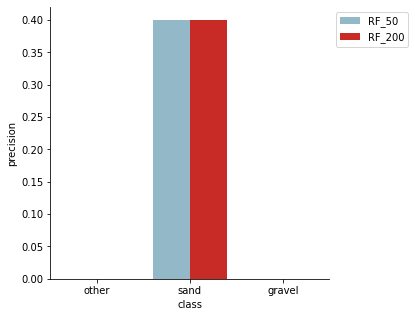

In [13]:



fig, ax = plt.subplots(figsize = (5, 5))
sns.barplot(x = 'class', y = 'precision', hue = 'model', data = df_class, ax = ax, palette = palette)
plt.legend(bbox_to_anchor = (1.3, 1))
sns.despine()
plt.show()


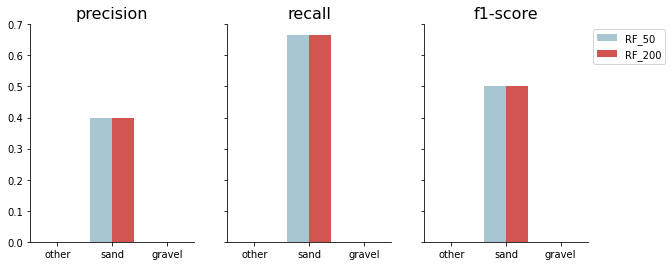

In [14]:

# sns.diverging_palette(120, 20)

fig, ax = plt.subplots(figsize = (10, 4), ncols = 3, sharex = True, sharey = True)

for i, colname in enumerate(cols):
    sns.barplot(x = 'class', y = colname, hue = 'model', data = df_class, ax = ax[i], palette = palette, alpha = 0.8)
    ax[i].set_title(colname, fontsize = 16)
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    if i < len(cols) - 1:
        ax[i].legend_.remove()
    
plt.legend(bbox_to_anchor = (1.5, 1))
sns.despine()
plt.show()

In [ ]:
# Red:
# #e3120b

# White:
# #fafafa

# Dark Gray:
# #4a4a4a

# Mid-green:
# #91b8bd

# Turquoise:
# #acc8d4

# Bright turq.:
# #9ae5de

# Light grey:
# #d4dddd

# Dark green:
# #244747

# Green:
# #336666

# Mid-blue:
# #8abbd0

# Beige:
# #efe8d1